<a href="https://colab.research.google.com/github/Gorodecki/Projects/blob/master/Machine_Quality_Steel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание**
Вам необходимо построить модель, которая на основании данных, поступающих каждую минуту, определяют качество продукции, производимое на обжиговой машине.


*   Обжиговая машина представляет собой агрегат, состоящий из 5 одинаковых по размеру камер, в каждой камере установлено по 3 датчика температур.

*   Кроме этого, для данной задачи Вы собрали данные о высоте слоя сырья и его влажности.Высота слоя и влажность измеряются ***при входе сырья в машину***.

*   Сырье проходит через обжиговую машину за час. Данные с показателями работы обжиговой машины содержатся в файле X_data.csv.

*    Качество продукции измеряется в лаборатории по пробам, которые забираются каждый час, данные по известным анализам содержатся в файле Y_train.csv.
*    В файле указано время забора пробы, ***проба забирается на выходе из обжиговой машины.***

> Вы договорились с заказчиком, что оценкой модели будет являться **показатель MAE**, для оценки модели необходимо сгенерировать предсказания за период, указанный в файле Y_submit.csv (5808 предиктов).



# Обработка данных.

In [ ]:
from tensorflow.keras.models import Sequential # НС прямого распространения
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from tensorflow.keras.optimizers import Adam # Алгоритмы оптимизации, для настройки скорости обучения
import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка изображений
import pandas as pd # Библиотека pandas
from google.colab import files, drive # Импорт файлов
from sklearn.model_selection import train_test_split
%matplotlib inline

Необходимо загрузить файлы в рабочую папку


---
https://drive.google.com/open?id=10S3E1LtOh6_dNkSu47SK0ryM2I0FGOsF

https://drive.google.com/open?id=1KcBTFWng658s8Ku6jXPDaqssy6zb9DuT

https://drive.google.com/open?id=1a3Sud-l57o05j77T_oOYrQpOO5cv57xh


In [ ]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/Seversteel'
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Seversteel
DS_test.docx	    Test2.7z	Y_submit.csv
statistic_2018.csv  X_data.csv	Y_train.csv


In [ ]:
X_data = pd.read_csv('X_data.csv', sep=';', encoding='utf-8')

In [ ]:
Y_train = pd.read_csv('Y_train.csv', sep=';', header=None, encoding='utf-8')
Y_submit = pd.read_csv('Y_submit.csv', sep=';', header=None, encoding='utf-8')

In [ ]:
#смотрим общий вид
X_data.head()

,Unnamed: 0,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22
1,2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22
2,2015-01-01 00:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99,9.22
3,2015-01-01 00:03:00,213,211,211,344,351,346,477,473,481,355,349,355,242,241,242,167.34,9.22
4,2015-01-01 00:04:00,213,211,211,343,350,346,478,473,482,358,349,355,243,241,242,163.04,9.22


In [ ]:
X_data.tail()

,Unnamed: 0,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
2103836,2018-12-31 23:56:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,157.20,8.44
2103837,2018-12-31 23:57:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,160.40,8.44
2103838,2018-12-31 23:58:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,160.14,8.44
2103839,2018-12-31 23:59:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,162.96,8.44
2103840,2019-01-01 00:00:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,159.73,7.35


In [ ]:
X_data.shape

(2103841, 18)

In [ ]:
Y_train.head()

,0,1
0,2015-01-04 00:05:00,392
1,2015-01-04 01:05:00,384
2,2015-01-04 02:05:00,393
3,2015-01-04 03:05:00,399
4,2015-01-04 04:05:00,400


In [ ]:
Y_train.tail()

,0,1
29179,2018-05-03 19:05:00,438
29180,2018-05-03 20:05:00,452
29181,2018-05-03 21:05:00,455
29182,2018-05-03 22:05:00,455
29183,2018-05-03 23:05:00,454


In [ ]:
Y_train.shape

(29184, 2)

In [ ]:
Y_submit.head()

,0,1
0,2018-05-04 00:05:00,420
1,2018-05-04 01:05:00,420
2,2018-05-04 02:05:00,420
3,2018-05-04 03:05:00,420
4,2018-05-04 04:05:00,420


In [ ]:
Y_submit.tail()

,0,1
5803,2018-12-31 19:05:00,420
5804,2018-12-31 20:05:00,420
5805,2018-12-31 21:05:00,420
5806,2018-12-31 22:05:00,420
5807,2018-12-31 23:05:00,420


In [ ]:
Y_submit.shape

(5808, 2)

In [ ]:
#смотрим пропуски и типы данных
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103841 entries, 0 to 2103840
Data columns (total 18 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  object 
 1   T_data_1_1  int64  
 2   T_data_1_2  int64  
 3   T_data_1_3  int64  
 4   T_data_2_1  int64  
 5   T_data_2_2  int64  
 6   T_data_2_3  int64  
 7   T_data_3_1  int64  
 8   T_data_3_2  int64  
 9   T_data_3_3  int64  
 10  T_data_4_1  int64  
 11  T_data_4_2  int64  
 12  T_data_4_3  int64  
 13  T_data_5_1  int64  
 14  T_data_5_2  int64  
 15  T_data_5_3  int64  
 16  H_data      float64
 17  AH_data     float64
dtypes: float64(2), int64(15), object(1)
memory usage: 288.9+ MB


In [ ]:
X_data.describe().round(0)

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
count,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0
mean,250.0,250.0,250.0,350.0,350.0,350.0,501.0,501.0,501.0,349.0,349.0,350.0,250.0,250.0,250.0,175.0,7.0
std,32.0,31.0,31.0,42.0,41.0,38.0,63.0,63.0,62.0,39.0,39.0,40.0,31.0,31.0,31.0,14.0,1.0
min,-198.0,-122.0,-107.0,-703.0,-958.0,-191.0,-775.0,-759.0,-613.0,-514.0,-471.0,-609.0,-89.0,-125.0,-163.0,141.0,3.0
25%,229.0,229.0,229.0,328.0,328.0,328.0,464.0,464.0,464.0,327.0,328.0,328.0,229.0,229.0,229.0,162.0,7.0
50%,250.0,250.0,250.0,350.0,350.0,350.0,502.0,502.0,502.0,349.0,350.0,350.0,249.0,250.0,250.0,174.0,8.0
75%,272.0,272.0,272.0,372.0,372.0,372.0,538.0,538.0,539.0,372.0,372.0,372.0,270.0,271.0,271.0,187.0,8.0
max,724.0,762.0,665.0,1302.0,1179.0,889.0,1587.0,2505.0,1319.0,1177.0,1244.0,944.0,905.0,738.0,624.0,208.0,12.0


In [ ]:
# разобьём столбцы по камерам 
T_data_group=[]
for i in range(1,14,3):
  T_data_group.append(X_data.columns[i:i+3])
len(T_data_group)

5

In [ ]:
# отрицательные значения температуры в печи - явный брак датчика (либо его остутствие или повреждение кабеля)
# заменим их на средние показания соседних датчиков из одной камеры
for i in range(len(T_data_group)):
  for j in range(len(T_data_group[0])):
    if j == 0:
      a = 1
      b = 2
      X_data.loc[X_data[T_data_group[i][j]] <= 0, T_data_group[i][j]] = (X_data.loc[X_data[T_data_group[i][j]] <= 0, T_data_group[i][a]] + X_data.loc[X_data[T_data_group[i][j]] <= 0, T_data_group[i][b]])//2
    elif j == 1:
      a = 0
      b = 2
      X_data.loc[X_data[T_data_group[i][j]] <= 0, T_data_group[i][j]] = (X_data.loc[X_data[T_data_group[i][j]] <= 0, T_data_group[i][a]] + X_data.loc[X_data[T_data_group[i][j]] <= 0, T_data_group[i][b]])//2
    elif j == 2:
      a = 0
      b = 1
      X_data.loc[X_data[T_data_group[i][j]] <= 0, T_data_group[i][j]] = (X_data.loc[X_data[T_data_group[i][j]] <= 0, T_data_group[i][a]] + X_data.loc[X_data[T_data_group[i][j]] <= 0, T_data_group[i][b]])//2

In [ ]:
X_data.describe().round(0)

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
count,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0,2103841.0
mean,250.0,250.0,250.0,350.0,350.0,350.0,502.0,501.0,502.0,350.0,350.0,350.0,250.0,250.0,250.0,175.0,7.0
std,31.0,30.0,30.0,39.0,37.0,37.0,61.0,61.0,60.0,38.0,36.0,37.0,31.0,30.0,30.0,14.0,1.0
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,141.0,3.0
25%,229.0,229.0,229.0,328.0,328.0,328.0,464.0,464.0,464.0,327.0,328.0,328.0,229.0,229.0,229.0,162.0,7.0
50%,250.0,250.0,250.0,350.0,350.0,350.0,502.0,502.0,502.0,349.0,350.0,350.0,249.0,250.0,250.0,174.0,8.0
75%,272.0,272.0,272.0,372.0,372.0,372.0,538.0,538.0,539.0,372.0,372.0,372.0,270.0,271.0,271.0,187.0,8.0
max,724.0,762.0,665.0,1302.0,1179.0,889.0,1587.0,2505.0,1319.0,1177.0,1244.0,944.0,905.0,738.0,624.0,208.0,12.0


In [ ]:
X_data['Unnamed: 0'] = pd.to_datetime(X_data['Unnamed: 0'])
X_data.head(60).describe().round(0)

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
count,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
mean,213.0,214.0,211.0,321.0,329.0,344.0,502.0,473.0,486.0,367.0,353.0,350.0,247.0,241.0,240.0,165.0,9.0
std,1.0,1.0,0.0,14.0,15.0,1.0,15.0,0.0,3.0,17.0,3.0,3.0,2.0,0.0,1.0,2.0,0.0
min,211.0,210.0,211.0,300.0,301.0,343.0,474.0,473.0,481.0,331.0,348.0,346.0,241.0,240.0,238.0,161.0,9.0
25%,213.0,213.0,211.0,309.0,317.0,344.0,490.0,473.0,484.0,355.0,352.0,348.0,245.0,241.0,239.0,164.0,9.0
50%,214.0,214.0,211.0,320.0,330.0,344.0,504.0,473.0,486.0,372.0,354.0,350.0,247.0,241.0,240.0,165.0,9.0
75%,214.0,214.0,211.0,332.0,342.0,345.0,514.0,473.0,489.0,382.0,356.0,352.0,248.0,241.0,241.0,167.0,9.0
max,214.0,215.0,212.0,347.0,353.0,347.0,522.0,473.0,490.0,386.0,356.0,355.0,249.0,241.0,243.0,171.0,9.0


# Модель "Качество продукции"

In [ ]:
#рассмотрим вариант средних значений за час
X_data_hour = X_data.resample('H', on='Unnamed: 0').mean()

# обратим внимание на разницу в начале отсчёта
res = X_data_hour.shape[0] - Y_train.shape[0] - Y_submit.shape[0] - 2
print('Различие от начала отсчёта составляет - ', res) 
print(X_data_hour.index[res])
print(Y_train[0][0])

Различие от начала отсчёта составляет -  71
2015-01-03 23:00:00
2015-01-04 00:05:00


In [ ]:
X_data_hour = X_data_hour[X_data_hour.index >= X_data_hour.index[res]]
X_data_hour = X_data_hour[X_data_hour.index <= X_data_hour.index[-3]]
print('Различие данных - ', X_data_hour.shape[0] - Y_train.shape[0] - Y_submit.shape[0])

Различие данных -  0


In [ ]:
X_data_hour.reset_index(drop=True, inplace=True)
Y_train.drop(columns=0, inplace=True)

In [ ]:
X = X_data_hour.to_numpy()
y_train = Y_train.to_numpy()

In [ ]:
x_train = X[:len(y_train)]
x_test = X[len(y_train):]

In [ ]:
#Нормализация данных
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train_scale = (x_train - mean) / std
x_test_scale = (x_test - mean) / std

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_submit.shape)

(29184, 17)
(5808, 17)
(29184, 1)
(5808, 2)


In [ ]:
# разделим данные для валидации
xTrain, xVal, yTrain, yVal = train_test_split(x_train_scale, y_train, test_size = 0.2, shuffle=True)

In [ ]:
model = Sequential()

model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(0.001), metrics='mae')
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 64)                1152      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64)                256       
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_31 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 33        
Total params: 3,521
Trainable params: 3,393
Non-trainable params: 128
_________________________________________________

In [ ]:
history = model.fit(xTrain, yTrain, batch_size=32, epochs=50, validation_data=(xVal, yVal) , verbose=1)

Epoch 1/50
730/730 [==============================] - 1s 2ms/step - loss: 66779.1484 - mae: 214.3281 - val_loss: 2420.0647 - val_mae: 39.9755
Epoch 2/50
730/730 [==============================] - 1s 2ms/step - loss: 7106.9893 - mae: 67.1004 - val_loss: 1021.4616 - val_mae: 23.8382
Epoch 3/50
730/730 [==============================] - 1s 2ms/step - loss: 5956.7329 - mae: 61.6100 - val_loss: 829.9701 - val_mae: 21.3068
Epoch 4/50
730/730 [==============================] - 1s 2ms/step - loss: 5330.6719 - mae: 58.0514 - val_loss: 636.2118 - val_mae: 18.3133
Epoch 5/50
730/730 [==============================] - 1s 2ms/step - loss: 4925.0630 - mae: 55.8170 - val_loss: 654.9406 - val_mae: 19.2431
Epoch 6/50
730/730 [==============================] - 1s 2ms/step - loss: 4568.3994 - mae: 53.8104 - val_loss: 574.0746 - val_mae: 17.1416
Epoch 7/50
730/730 [==============================] - 1s 2ms/step - loss: 4207.4146 - mae: 51.5889 - val_loss: 608.9209 - val_mae: 19.0852
Epoch 8/50
730/730 [===

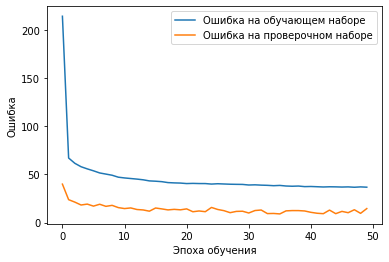

In [ ]:
#Оображаем график точности обучения
plt.plot(history.history['mae'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

# Вывод оценки Модели

In [ ]:
predict = model.predict(xVal)
MAE = np.abs(np.subtract(yVal,predict)).mean()
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(yVal)/len(yVal)
print("Средняя ошибка: ", round(MAE))
print("Средняя оценка: ", round(mean_price[0]))
print("Процент ошибки: ", round(100*MAE / mean_price[0]), "%", sep="")

Средняя ошибка:  15.0
Средняя оценка:  402.0
Процент ошибки: 4.0%


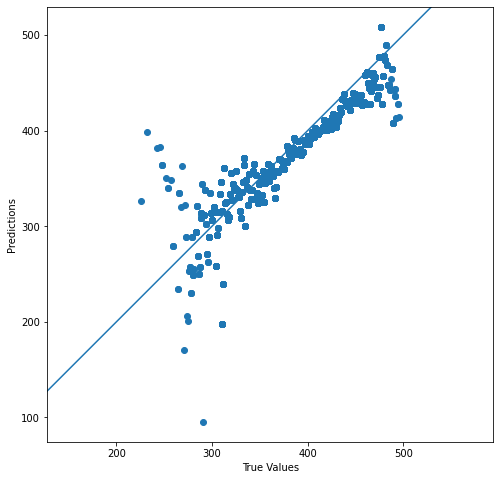

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(yVal, predict)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-1000, 1000], [-1000, 1000])

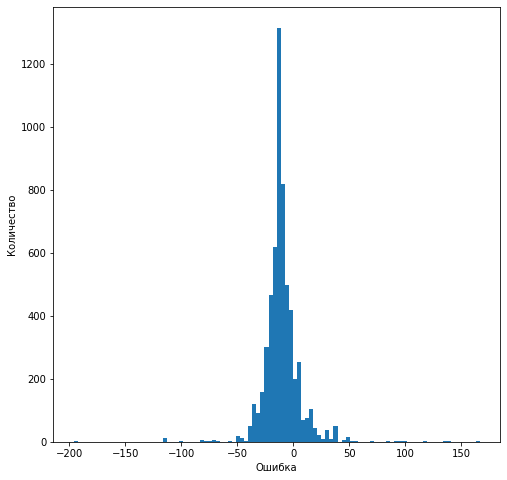

In [ ]:
plt.figure(figsize=(8,8))
error = predict - yVal
plt.hist(error, bins = 100)
plt.xlabel("Ошибка")
_ = plt.ylabel("Количество")

In [ ]:
submit = model.predict(x_test_scale)

In [ ]:
Y_submit[1] = submit.round(0)
Y_submit.head()

,0,1
0,2018-05-04 00:05:00,399.0
1,2018-05-04 01:05:00,418.0
2,2018-05-04 02:05:00,359.0
3,2018-05-04 03:05:00,384.0
4,2018-05-04 04:05:00,352.0


In [ ]:
Y_submit.to_csv('Y_submit_Nekrasov_NN.csv', sep=';')